## Data Cleaning and Data Preprocessing

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
df = pd.read_csv('mv.csv')
df.columns = df.columns.str.strip()  
# Filling missing values
df['Revenue (Millions)'].fillna(df['Revenue (Millions)'].median(), inplace=True)
df['Metascore'].fillna(df['Metascore'].median(), inplace=True)
df


,Rank,Title,Genre,Description,Director,Actors,Year,Runtime (Minutes),Rating,Votes,Revenue (Millions),Metascore
0,1,Guardians of the Galaxy,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.130,76.0
1,2,Prometheus,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.460,65.0
2,3,Split,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.120,62.0
3,4,Sing,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.320,59.0
4,5,Suicide Squad,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.020,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...
995,996,Secret in Their Eyes,"Crime,Drama,Mystery","A tight-knit team of rising investigators, alo...",Billy Ray,"Chiwetel Ejiofor, Nicole Kidman, Julia Roberts...",2015,111,6.2,27585,47.985,45.0
996,997,Hostel: Part II,Horror,Three American college students studying abroa...,Eli Roth,"Lauren German, Heather Matarazzo, Bijou Philli...",2007,94,5.5,73152,17.540,46.0
997,998,Step Up 2: The Streets,"Drama,Music,Romance",Romantic sparks occur between two dance studen...,Jon M. Chu,"Robert Hoffman, Briana Evigan, Cassie Ventura,...",2008,98,6.2,70699,58.010,50.0
998,999,Search Party,"Adventure,Comedy",A pair of friends embark on a mission to reuni...,Scot Armstrong,"Adam Pally, T.J. Miller, Thomas Middleditch,Sh...",2014,93,5.6,4881,47.985,22.0


## Generate meaningful features

In [10]:
df['Title_Length'] = df['Title'].apply(len)
df['Description_Length'] = df['Description'].apply(len)
df['Num_Actors'] = df['Actors'].apply(lambda x: len(x.split(',')))
df['Genre_Count'] = df['Genre'].apply(lambda x: len(x.split(',')))
df['Genre'] = df['Genre'].apply(lambda x: x.split(',')[0])  
# Taking the first genre as a representative
df = pd.get_dummies(df, columns=['Genre', 'Director'], drop_first=True)
# Features and target variable
features = ['Year', 'Runtime (Minutes)', 'Rating', 'Votes', 'Revenue (Millions)', 'Metascore', 
            'Title_Length', 'Description_Length', 'Num_Actors', 'Genre_Count'] + \
           [col for col in df.columns if col.startswith('Genre_')] + \
           [col for col in df.columns if col.startswith('Director_')]

X = df[features]
y = df['Rating']

# Standardized  features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


##  Principal Component Analysis (PCA)
###  predection and evaluation

In [3]:
# Principal Component Analysis (PCA)
pca = PCA(n_components=0.95)  # Keep 95% of the variance
X_pca = pca.fit_transform(X_scaled)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Train a RandomForestRegressor to determine feature importance
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = rf.predict(X_test)
print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred)}')
print(f'R2 Score: {r2_score(y_test, y_pred)}')


Mean Squared Error: 0.1527874599999998
R2 Score: 0.8406079719246708


# Feature Importance from RandomForest
## GridSearchCV for hyperparameter tuning of RandomForest

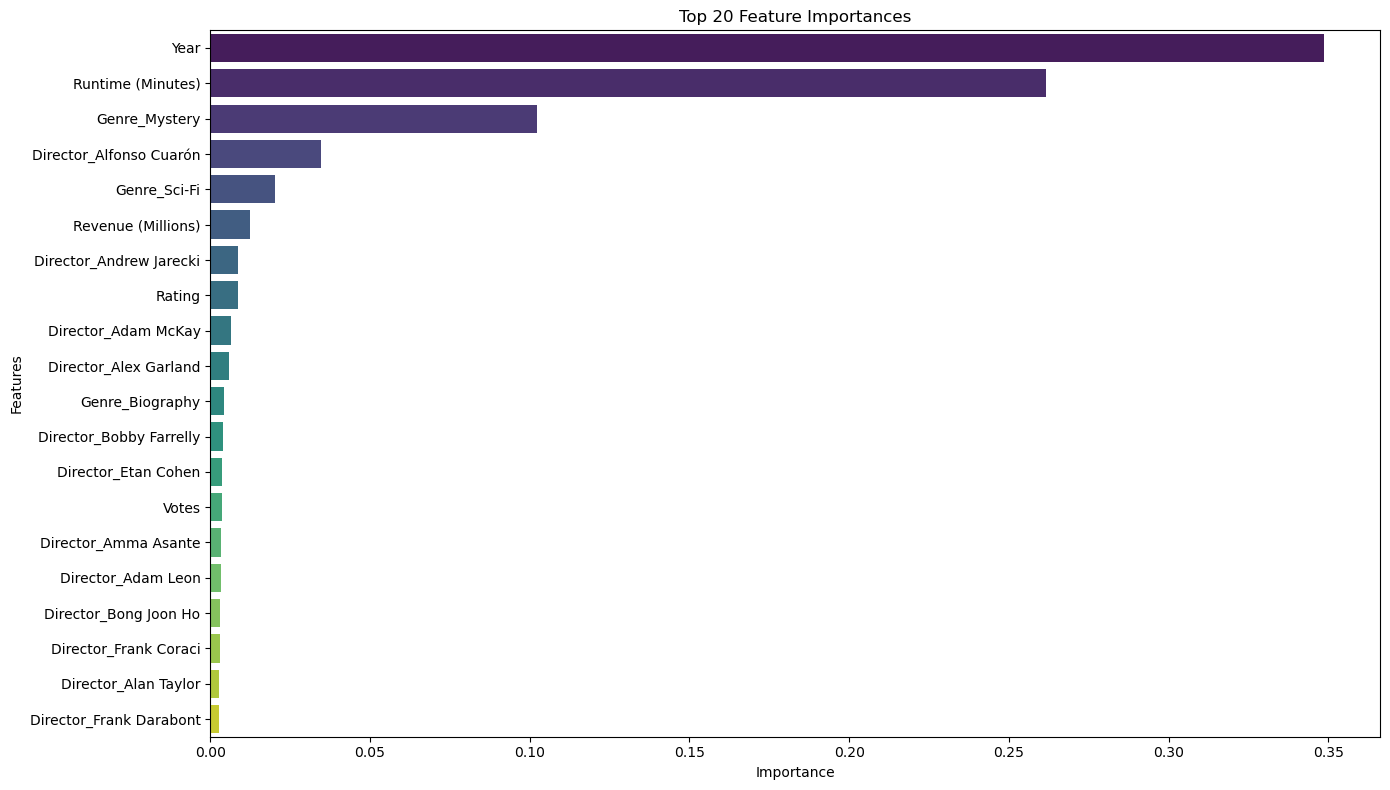

Fitting 3 folds for each of 324 candidates, totalling 972 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': [1.0, 'sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [6]:
# Feature Importance from RandomForest
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = [features[i] for i in indices]

# Selected the top 20 most important features
top_n = 20
top_indices = indices[:top_n]
top_importances = importances[top_indices]
top_feature_names = [features[i] for i in top_indices]

# Plot 
plt.figure(figsize=(14, 8))
sns.barplot(x=top_importances, y=top_feature_names, palette="viridis")
plt.title('Top 20 Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.tight_layout()
plt.show()
# Selectd the most important features based on feature importance
threshold = 0.01  # Threshold for feature importance
important_indices = indices[importances[indices] > threshold]
#GridSearchCV for hyperparameter tuning of RandomForest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_features': [1.0, 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train[:, important_indices], y_train)

# Predictd and evaluated the model with optimized parameters

In [7]:
# Best parameters from GridSearchCV
print(f'Best Parameters: {grid_search.best_params_}')
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test[:, important_indices])
print(f'Mean Squared Error (Optimized): {mean_squared_error(y_test, y_pred_best)}')
print(f'R2 Score (Optimized): {r2_score(y_test, y_pred_best)}')

Best Parameters: {'max_depth': 20, 'max_features': 1.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Mean Squared Error (Optimized): 0.12521761714253685
R2 Score (Optimized): 0.8693695808078158
